In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(n_workers=2, threads_per_worker=2,dashboard_address=':8888')

client = Client(cluster)
client


Client Scheduler: tcp://127.0.0.1:38097 Dashboard: http://127.0.0.1:8888/status,Cluster Workers: 2 Cores: 4 Memory: 35.01 GB


In [2]:
## Path for modules

import sys

import numpy as np
import xarray as xr

from netCDF4 import Dataset

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime
from xhistogram.xarray import histogram

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

In [3]:
## Dataset

data_dirT0 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLBT02-S/1h/ACO/'
data_dir00 = '/mnt/meom/workdir/henelle/eNATL60/eNATL60-BLB002-S/1h/ACO/'

In [4]:
## All files, JAS

# No tide
tfilename_strain00 = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_strain10m.nc'
tfilename_curl00   = data_dir00 + 'eNATL60ACO-BLB002_y2009*.1h_curl10m.nc'

# Tide
tfilename_strainT0 = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_strain10m.nc'
tfilename_curlT0   = data_dirT0 + 'eNATL60ACO-BLBT02_y2009*.1h_curl10m.nc'

In [5]:
fstrain00 = xr.open_mfdataset(tfilename_strain00,combine='by_coords',parallel=True,chunks={'time_counter':24})
strain00 = fstrain00['sostrainoverf'][:]
navlat = fstrain00['nav_lat'][0]
navlon = fstrain00['nav_lon'][0]

fstrainT0 = xr.open_mfdataset(tfilename_strainT0,combine='by_coords',parallel=True,chunks={'time_counter':24})
strainT0=fstrainT0['sostrainoverf'][:]

fcurl00 = xr.open_mfdataset(tfilename_curl00,combine='by_coords',parallel=True,chunks={'time_counter':24})
curl00=fcurl00['socurloverf'][:]

fcurlT0   = xr.open_mfdataset(tfilename_curlT0,combine='by_coords',parallel=True,chunks={'time_counter':24})
curlT0 = fcurlT0['socurloverf'][:]

In [6]:
print(strainT0)
print(navlon)

<xarray.DataArray 'sostrainoverf' (time_counter: 2208, y: 1191, x: 781)>
dask.array<concatenate, shape=(2208, 1191, 781), dtype=float32, chunksize=(24, 1191, 781), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2009-09-30T23:30:00
Dimensions without coordinates: y, x
Attributes:
    units:             -
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Relative_Vorticity (strain)
    short_name:        sostrain
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0
<xarray.DataArray 'nav_lon' (y: 1191, x: 781)>
dask.array<getitem, shape=(1191, 781), dtype=float32, chunksize=(1191, 781), chunktype=numpy.ndarray>
Coordinates:
    time_counter  datetime64[ns] 2009-07-01T00:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east


In [7]:
T=2*np.pi/(1E-4) # Coriolis period
# Frequencies higher than half Coriolis (~35h) are filtered for U and V
# size of window chosen as 48 by previous calc by Aurélie
# 2T chosen to filter the higher frequencies (those connected with the tide)
# Need to filter well the higher frequencies so we can compare influence of tide or not

In [8]:
wstrainT0 = strainT0.window
wstrainT0.set(n=48,dim='time_counter', cutoff=2*T)
strainT0_filt = wstrainT0.convolve()

In [9]:
wstrain00 = strain00.window
wstrain00.set(n=48,dim='time_counter', cutoff=2*T)
strain00_filt = wstrain00.convolve()

In [10]:
wcurlT0 = curlT0.window
wcurlT0.set(n=48,dim='time_counter', cutoff=2*T)
curlT0_filt = wcurlT0.convolve()

In [11]:
wcurl00 = curl00.window
wcurl00.set(n=48,dim='time_counter', cutoff=2*T)
curl00_filt = wcurl00.convolve()
curl00_filt

<xarray.DataArray 'socurloverf' (time_counter: 2208, y: 1191, x: 781)>
dask.array<mul, shape=(2208, 1191, 781), dtype=float32, chunksize=(24, 1191, 781), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2009-09-30T23:30:00
Dimensions without coordinates: y, x

In [12]:
## Selecting box

#box    = (-31.5,-27,30.6,36)
#box    = (-34.0,-31.5,25.2,28.8)
#box    = (-34.0,-31.5,34.2,37.8)
#box    = (-34.5,-32.0,34.8,38.4)
#box    = (-35.0,-32.5,35.4,39.0)

box=(-31,-28,33,36)
domain=(box[0]<navlon)*(navlon<box[1])*(box[2]<navlat)*(navlat<box[3])
where=np.where(domain)

In [13]:
jmin = where[0][0]
jmax = where[0][-1]
imin = where[1][0]
imax = where[1][-1]

In [14]:
print('jmin = '+str(jmin)+'; jmax = '+str(jmax))
print('imin = '+str(imin)+'; imax = '+str(imax))

jmin = 667; jmax = 882
imin = 384; imax = 563


In [15]:
# stack makes it 1D for it to be used for the histograms
# could potentially stock the filtered values of only the box, not the whole region
strainT0_filtbox = strainT0_filt[:,jmin:jmax+1,imin:imax+1]#.stack(z=('x', 'y','time_counter'))
strain00_filtbox = strain00_filt[:,jmin:jmax+1,imin:imax+1]#.stack(z=('x', 'y','time_counter'))
curlT0_filtbox = curlT0_filt[:,jmin:jmax+1,imin:imax+1]#.stack(z=('x', 'y','time_counter'))
curl00_filtbox = curl00_filt[:,jmin:jmax+1,imin:imax+1]#.stack(z=('x', 'y','time_counter'))
curl00_filtbox

<xarray.DataArray 'socurloverf' (time_counter: 2208, y: 216, x: 180)>
dask.array<getitem, shape=(2208, 216, 180), dtype=float32, chunksize=(24, 216, 180), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2009-09-30T23:30:00
Dimensions without coordinates: y, x

In [16]:
sbins = np.arange(0.0,0.5, 0.025)
cbins = np.arange(-0.5,0.5, 0.025)

In [17]:
hist_JAS_strain00_filtbox = histogram(strain00_filtbox,bins=[sbins])
hist_JAS_strainT0_filtbox = histogram(strainT0_filtbox,bins=[sbins])
hist_JAS_curl00_filtbox   = histogram(curl00_filtbox,bins=[cbins])
hist_JAS_curlT0_filtbox   = histogram(curlT0_filtbox,bins=[cbins])

In [22]:
def plot_surf(data1,data2,lon,lat,i,lonmin,lonmax,latmin,latmax,vmin_data1,vmax_data1,vmin_data2,vmax_data2,cmap_data1,cmap_data2,var_title_data1,var_title_data2,date,season):
    
    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    
    ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())#221
    ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())#222
    
    # Adjust subplots
    plt.subplots_adjust(hspace=0.0,wspace=0.1)
    
    norm_fld_data1 = colors.Normalize(vmin=vmin_data1, vmax=vmax_data1, clip=False)
    norm_fld_data2 = colors.Normalize(vmin=vmin_data2, vmax=vmax_data2, clip=False)
    
    pcolor1 = ax1.pcolormesh(lon,lat,data1,cmap=cmap_data1,vmin=vmin_data1,vmax=vmax_data1,norm = norm_fld_data1)
    pcolor2 = ax2.pcolormesh(lon,lat,data2,cmap=cmap_data2,vmin=vmin_data2,vmax=vmax_data2,norm = norm_fld_data2)
    
    # Add the Azores
    land = cfeature.GSHHSFeature(scale='intermediate',
                                 levels=[1],
                                 facecolor='dimgray')
    ax1.add_feature(land)
    ax2.add_feature(land)
    
    
    # Colorbar ax1
    cax1,kw1   = mpl.colorbar.make_axes(ax1,location='bottom',pad=0.05,shrink=0.95)
    out1       = fig.colorbar(pcolor1,cax=cax1,extend='both',**kw1)
    out1.set_label(var_title_data1,size=16)
    out1.ax.tick_params(labelsize=16)
    xticks_ax1 = np.linspace(vmin_data1,vmax_data1,num=5)
    out1.set_ticks(xticks_ax1)
    
    # Colorbar ax2
    cax2,kw2   = mpl.colorbar.make_axes(ax2,location='bottom',pad=0.05,shrink=0.95)
    out2       = fig.colorbar(pcolor2,cax=cax2,extend='max',**kw2)
    out2.set_label(var_title_data2,size=16)
    out2.ax.tick_params(labelsize=16)
    xticks_ax2 = np.linspace(vmin_data2,vmax_data2,num=5)
    out2.set_ticks(xticks_ax2)
    
    # Grid    
    gl1            = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl1.xformatter = LONGITUDE_FORMATTER
    gl1.yformatter = LATITUDE_FORMATTER
    gl1.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl1.xlabels_top = False
    gl1.ylabels_right = False
    gl2            = ax2.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,lw=1,color='gray',alpha=0.8, ls='--')
    gl2.xformatter = LONGITUDE_FORMATTER
    gl2.yformatter = LATITUDE_FORMATTER
    gl2.xlabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.ylabel_style = {'size': 13, 'color': 'dimgray'}
    gl2.xlabels_top = False
    gl2.ylabels_right = False
    gl2.ylabels_left = False
    
    # Adjusting axes
    ax1.set_xlim((-36, -26))
    ax1.set_ylim((25, 40))
    ax2.set_xlim((-36, -26))
    ax2.set_ylim((25, 40))
    
    
    # Chosen region
    ax1.plot([lonmin, lonmax], [latmin, latmin],color='black',linewidth=4)
    ax1.plot([lonmin, lonmax], [latmax, latmax],color='black',linewidth=4)
    ax1.plot([lonmin, lonmin], [latmin, latmax],color='black',linewidth=4)
    ax1.plot([lonmax, lonmax], [latmin, latmax],color='black',linewidth=4)
    ax2.plot([lonmin, lonmax], [latmin, latmin],color='black',linewidth=4)
    ax2.plot([lonmin, lonmax], [latmax, latmax],color='black',linewidth=4)
    ax2.plot([lonmin, lonmin], [latmin, latmax],color='black',linewidth=4)
    ax2.plot([lonmax, lonmax], [latmin, latmax],color='black',linewidth=4)
    
    
    # Figure titles
    ts = pd.to_datetime(str(date))
    d = ts.strftime('%d/%m/%y %H:%M')
    
    ax1.set_title(var_title_data1+' no tide; '+str(d),size=16, y=1.05)
    ax2.set_title(var_title_data2+' no tide; '+str(d),size=16, y=1.05)
    

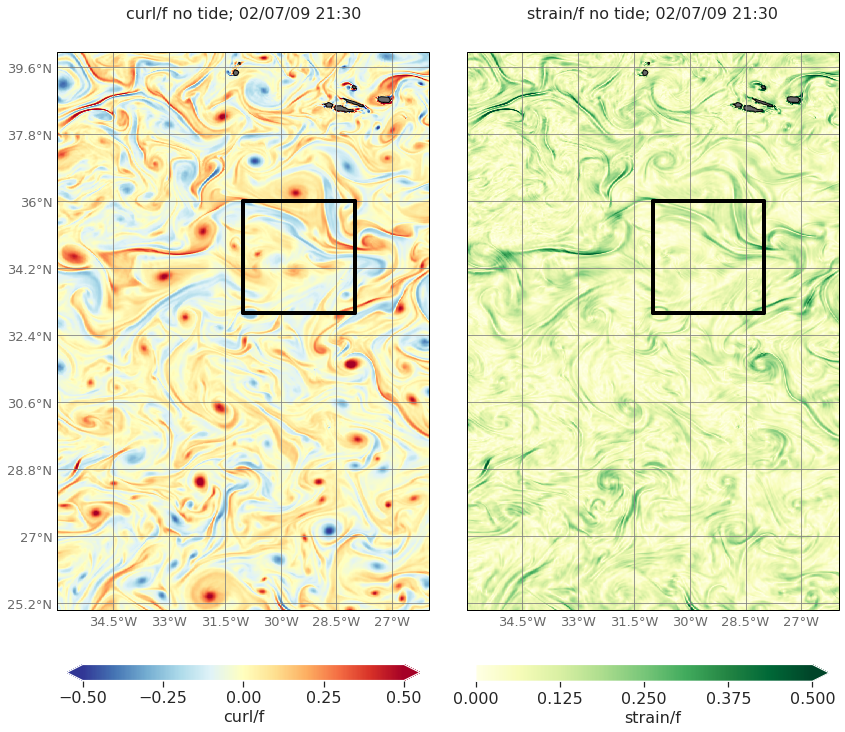

In [23]:
plot_surf(curl00[45,:,:],strain00[45,:,:],navlon,navlat,45,-31,-28,33,36,vmin_data1=-0.5,vmax_data1=0.5,vmin_data2=0,vmax_data2=0.5,
                     cmap_data1='RdYlBu_r',cmap_data2='YlGn',var_title_data1='curl/f',var_title_data2='strain/f',
                     date=str(strain00.time_counter.values[45]),season='JAS')

In [28]:
def plot_histo(hist_data1_00,hist_data1_T0,hist_data2_00,hist_data2_T0,var_title_data1,var_title_data2):
    
    fig = plt.figure(figsize=(14,20))
    gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[2]) 
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
   
  
    # Adding histograms
    hist_data1_00.plot(ax=ax1,label='no tide',lw=3.0,color='lightseagreen')
    hist_data1_T0.plot(ax=ax1,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax1.set_xlabel('24h filtered '+var_title_data1,size=16)
    ax1.set_ylabel('')
    ax1.tick_params(labelsize=15)

    hist_data2_00.plot(ax=ax2,label='no tide',lw=3.0,color='lightseagreen')
    hist_data2_T0.plot(ax=ax2,label='tide',lw=3.0,linestyle='-.',color='darkred')
    ax2.set_xlabel('24h filtered '+var_title_data2,size=16)
    ax2.set_ylabel('')
    ax2.tick_params(labelsize=15)
    
    ax1.set_xlim((-0.5,0.5))
    ax2.set_xlim((0,0.5))
    
    
    

CPU times: user 2min 30s, sys: 9.07 s, total: 2min 39s
Wall time: 26min 44s


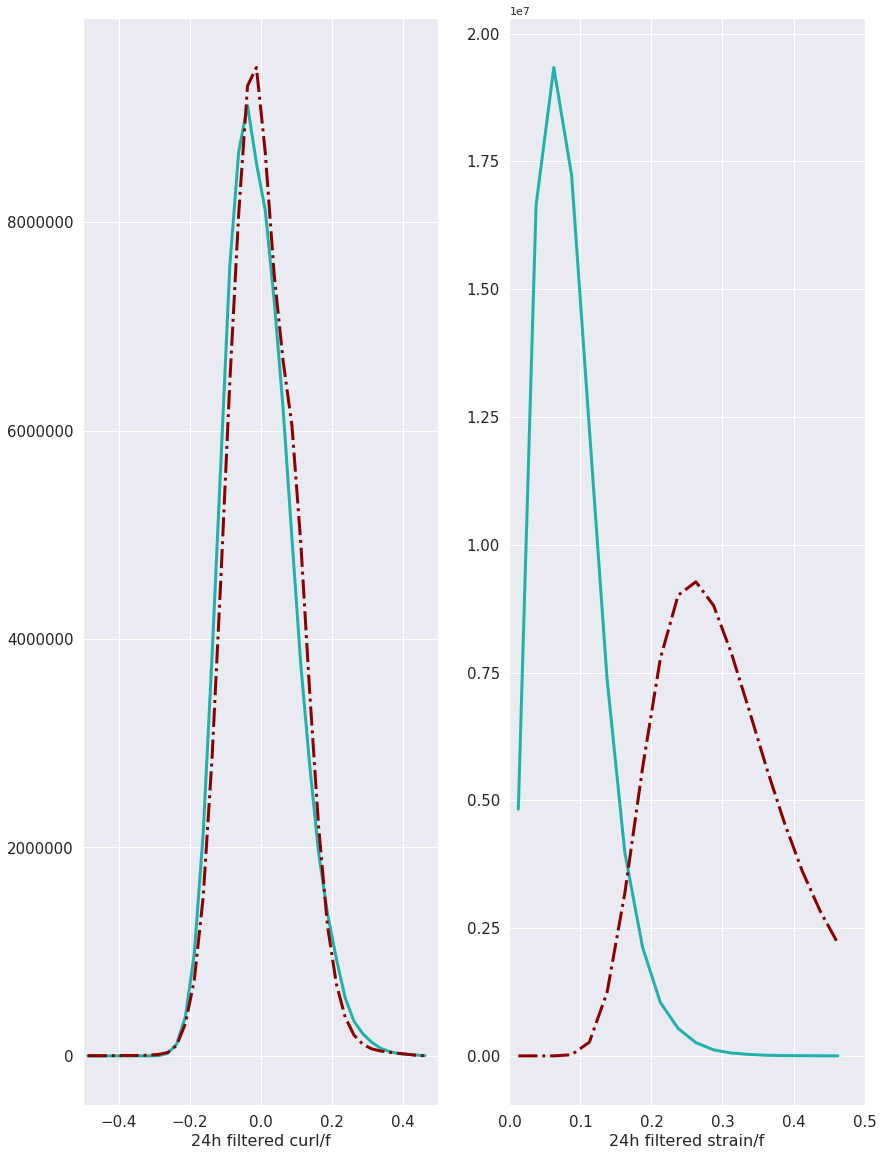

In [29]:
%%time

plot_histo(hist_JAS_curl00_filtbox,hist_JAS_curlT0_filtbox,hist_JAS_strain00_filtbox,hist_JAS_strainT0_filtbox,var_title_data1='curl/f',var_title_data2='strain/f')